In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from textblob import TextBlob
import spacy
from spacy import displacy

In [31]:
wine = pd.read_csv('winemag-data-130k-v2.csv.zip')

In [32]:
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [33]:
wine = pd.read_csv('winemag-data-130k-v2.csv.zip', index_col=0)

#removed index column from the csv file

In [34]:
wine.shape

(129971, 13)

In [35]:
wine[wine.duplicated(['description','title'])].shape[0]
#9983 descriptions are duplicates

9983

In [36]:
wine = wine.drop_duplicates(['description','title'])
wine.shape

(119988, 13)

In [37]:
wine.isnull().sum().sort_values(ascending=False)

region_2                 73219
designation              34545
taster_twitter_handle    29446
taster_name              24917
region_1                 19560
price                     8395
province                    59
country                     59
variety                      1
winery                       0
title                        0
points                       0
description                  0
dtype: int64

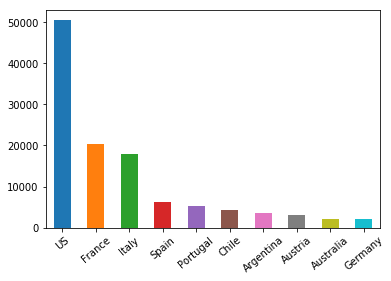

In [38]:
wine['country'].value_counts()[:10].plot(kind='bar',rot=40)
plt.show()

#largest 10 wine producers in this dataset

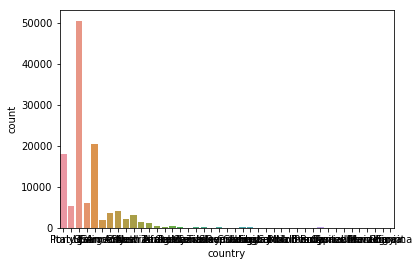

In [23]:
sns.countplot(x = "country", data = wine)

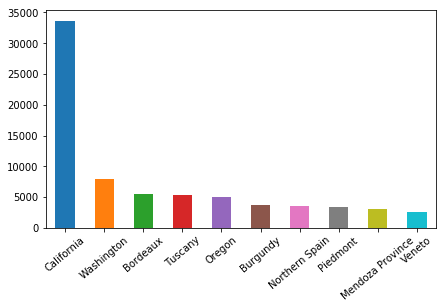

In [45]:
wine['province'].value_counts()[:10].plot(kind='bar', rot=40,figsize=(7,4))
plt.show()

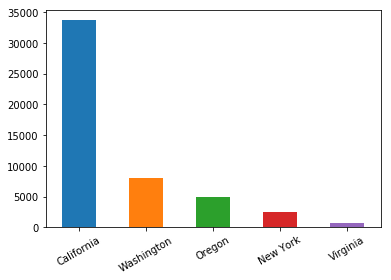

In [46]:
wine[wine['country']=='US']['province'].value_counts()[:5].plot(kind='bar',rot=30)
plt.show()

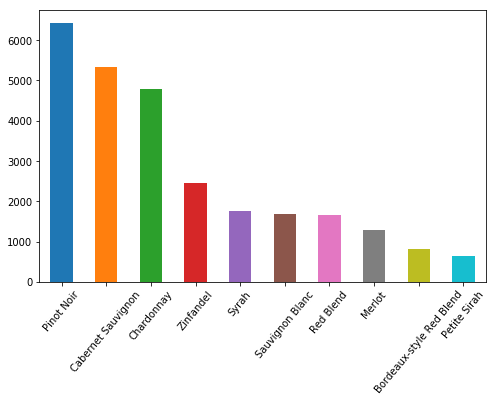

In [48]:
wine[wine['province']=='California']['variety'].value_counts()[:10].plot(kind='bar', figsize = (8,5), rot=50)
plt.show()

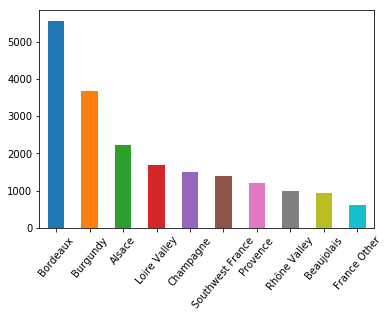

In [49]:
wine[wine['country']=='France']['province'].value_counts()[:10].plot(kind='bar',rot=50)
plt.show()

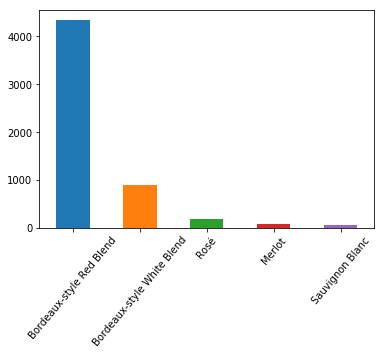

In [50]:
wine[wine['province']=='Bordeaux']['variety'].value_counts()[:5].plot(kind='bar',rot=50)
plt.show()

In [51]:
wine.variety.value_counts()[:10]

Pinot Noir                  12278
Chardonnay                  10868
Cabernet Sauvignon           8840
Red Blend                    8243
Bordeaux-style Red Blend     6471
Riesling                     4773
Sauvignon Blanc              4575
Syrah                        3828
Rosé                         3220
Merlot                       2896
Name: variety, dtype: int64

In [52]:
wine_variety = wine.variety.unique()
len(wine_variety)

#708 unique wine types 

708

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


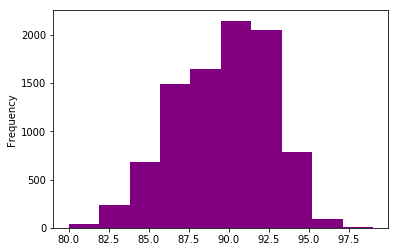

In [53]:
US_pinotnoir = wine[wine['country'] == 'US'][wine['variety']== 'Pinot Noir']
US_pinotnoir['points'].plot(kind='hist', color = 'purple')

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


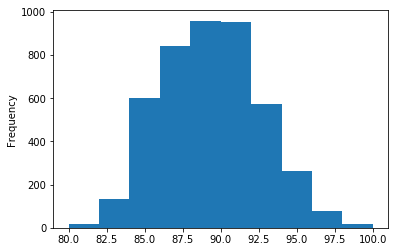

In [54]:
Fra_pinotnoir = wine[wine['country'] == 'France'][wine['variety']== 'Bordeaux-style Red Blend']
Fra_pinotnoir['points'].plot(kind='hist')

In [21]:
ita_pinotnoir = wine[wine['country'] == 'Italy'][wine['variety']== 'Pinot Noir']
esp_pinotnoir = wine[wine['country'] == 'Spain'][wine['variety']== 'Pinot Noir']

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5,1,'France Pinot Noir Wine Mag rankings')

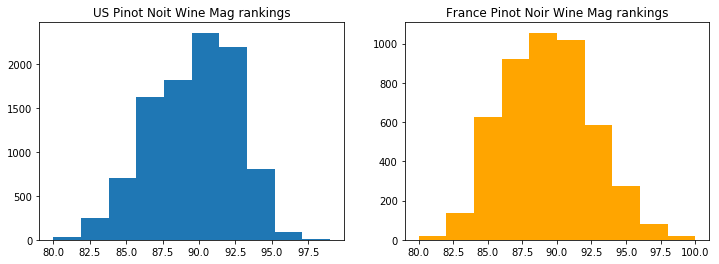

In [22]:
plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.hist(US_pinotnoir['points'])
plt.title('US Pinot Noit Wine Mag rankings')

plt.subplot(1,2,2)
plt.hist(Fra_pinotnoir['points'], color = 'orange')
plt.title('France Pinot Noir Wine Mag rankings')


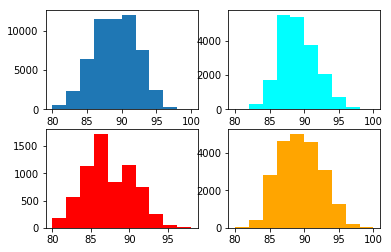

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2)


plt.subplot(2,2,1)
us_rating = wine[wine['country']== 'US']['points']
plt.hist(us_rating)

plt.subplot(2,2,2)
ita_rating = wine[wine['country']== 'Italy']['points']
plt.hist(ita_rating, color='aqua')

plt.subplot(2,2,3)
esp_rating = wine[wine['country']== 'Spain']['points']
plt.hist(esp_rating, color='red')

plt.subplot(2,2,4)
fra_rating = wine[wine['country']== 'France']['points']
plt.hist(fra_rating, color='orange')

plt.show()

In [55]:
wine.points.describe()

count    119988.000000
mean         88.442236
std           3.092915
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [56]:
wine[wine['points'] > 88.5].shape

(56737, 13)

In [57]:
wine[wine['points'] < 88.5].shape

(63251, 13)

In [58]:
tasters = wine['taster_name'].value_counts()
len(tasters)

19

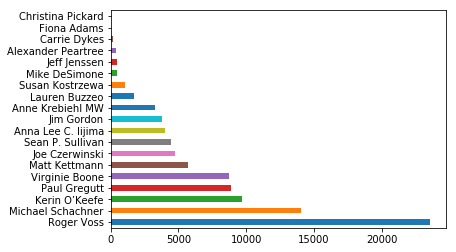

In [59]:
tasters.plot(kind='barh')
plt.show()

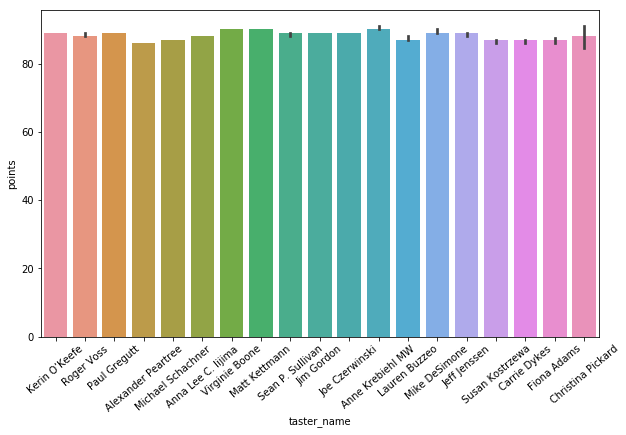

In [64]:
plt.figure(figsize=(10,6))
from numpy import median
ax = sns.barplot(x = 'taster_name', y='points', data=wine , estimator=median)
 
for item in ax.get_xticklabels():
    item.set_rotation(40)

In [65]:
wine.groupby(['taster_name'])['points'].mean()

taster_name
Alexander Peartree    85.780679
Anna Lee C. Iijima    88.416480
Anne Krebiehl MW      90.625228
Carrie Dykes          86.356589
Christina Pickard     87.833333
Fiona Adams           86.750000
Jeff Jenssen          88.330275
Jim Gordon            88.603558
Joe Czerwinski        88.524339
Kerin O’Keefe         88.897803
Lauren Buzzeo         87.692941
Matt Kettmann         90.061431
Michael Schachner     86.857112
Mike DeSimone         89.125813
Paul Gregutt          89.094159
Roger Voss            88.733107
Sean P. Sullivan      88.754988
Susan Kostrzewa       86.575758
Virginie Boone        89.220946
Name: points, dtype: float64

In [66]:
wine['variety'].fillna(value = 'Unknown', inplace=True)

In [67]:
wine['variety'].isnull().value_counts()

False    119988
Name: variety, dtype: int64

In [68]:
wine[wine['country']]['variety'].sum()

ValueError: cannot index with vector containing NA / NaN values

In [69]:
wine['country'].isnull().value_counts()

False    119929
True         59
Name: country, dtype: int64

In [70]:
wine['country'].fillna(value = 'Unknown', inplace=True)
wine['country'].isnull().value_counts()

False    119988
Name: country, dtype: int64

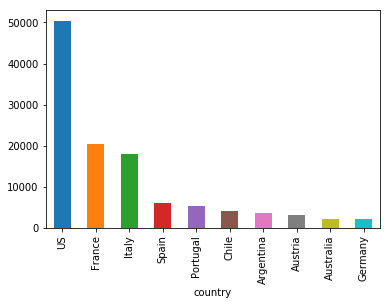

In [71]:
country_variety = wine.groupby('country')['variety'].size()
country_variety
country_variety.sort_values(ascending = False)[:10].plot.bar()



In [77]:
wine[(wine['region_1']) != (wine['region_2'])]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
11,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer


In [79]:
def name_split(string):
   brian = string.split(sep='(')
   brian1 = brian[-1].split(sep=')')
   return brian1[0]
wine['region'] = wine['title'].map(name_split)
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,region
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Etna
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Douro
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Willamette Valley
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Lake Michigan Shore
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley


In [47]:
list(wine.title[30:45])

#looking to pull year of vintage out of the title
#also inside parenthesis is the Region, can use this to fill in NaN values

['Domaine de la Madone 2012 Nouveau  (Beaujolais-Villages)',
 "Duca di Salaparuta 2010 Calanìca Nero d'Avola-Merlot Red (Sicilia)",
 'Duca di Salaparuta 2011 Calanìca Grillo-Viognier White (Sicilia)',
 'Envolve 2010 Puma Springs Vineyard Red (Dry Creek Valley)',
 'Envolve 2011 Sauvignon Blanc (Sonoma Valley)',
 'Erath 2010 Hyland Pinot Noir (McMinnville)',
 'Estampa 2011 Estate Viognier-Chardonnay (Colchagua Valley)',
 'Feudi del Pisciotto 2010 Missoni Cabernet Sauvignon (Sicilia)',
 'Feudi di San Marzano 2011 I Tratturi Primitivo (Puglia)',
 "Feudo di Santa Tresa 2011 Purato Made With Organic Grapes Nero d'Avola (Sicilia)",
 'Feudo Montoni 2011 Catarratto (Sicilia)',
 'Hawkins Cellars 2009 Pinot Noir (Willamette Valley)',
 'Henry Fessy 2012 Nouveau  (Beaujolais)',
 'Robert Hall 2011 Sauvignon Blanc (Paso Robles)',
 'Sundance 2011 Merlot (Maule Valley)']

In [48]:
wine['title'].str.split()[:4]

0               [Nicosia, 2013, Vulkà, Bianco, (Etna)]
1    [Quinta, dos, Avidagos, 2011, Avidagos, Red, (...
2    [Rainstorm, 2013, Pinot, Gris, (Willamette, Va...
3    [St., Julian, 2013, Reserve, Late, Harvest, Ri...
Name: title, dtype: object

In [49]:
wine['title'].str.split().str.get(4)[:4]

0         (Etna)
1       Avidagos
2    (Willamette
3           Late
Name: title, dtype: object

In [50]:
[int(s) for s in wine['title'].str.split()[4] if s.isdigit()]

[2012]

In [51]:
wine['title'] = wine['title'].astype(str)

In [52]:
wine['year'] = wine.title.str.extract('(\d{4})')

In [53]:
wine['year'].head()

0    2013
1    2011
2    2013
3    2013
4    2012
Name: year, dtype: object

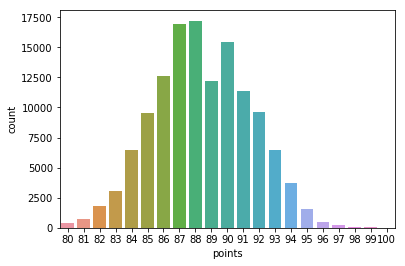

In [54]:
sns.countplot(wine['points']) 

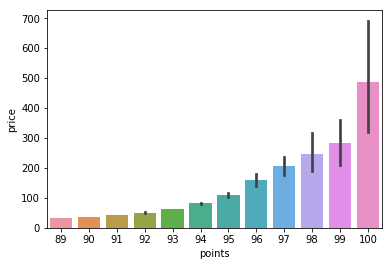

In [55]:
ax = sns.barplot(x="points", y="price", data=wine[wine['points']>88.5])

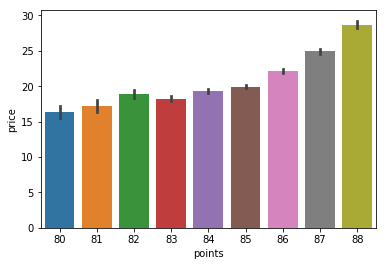

In [56]:
ax = sns.barplot(x="points", y="price", data=wine[wine['points']<88.5])

In [57]:
from datetime import datetime
wine['year'] = pd.to_datetime(wine.year, errors = 'coerce')
wine.info()
wine['year']= wine.year.dt.year

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 14 columns):
country                  129971 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129971 non-null object
winery                   129971 non-null object
year                     125331 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(11)
memory usage: 19.9+ MB


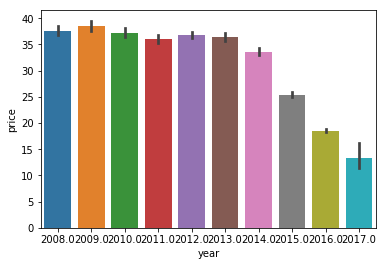

In [60]:
ax = sns.barplot(x="year", y="price", data=wine[wine['year']>2007])

### Working with NLP and textblob on wine description 

In [61]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import sent_tokenize
import re

In [62]:
wine.description[3]

'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.'

In [63]:
review = wine.description[3]

In [84]:
analysis = TextBlob(review)

In [67]:
analysis.noun_phrases

WordList(['pineapple', 'lemon pith', 'orange blossom', 'semidry finish'])

In [68]:
analysis.sentiment

Sentiment(polarity=0.16666666666666669, subjectivity=0.3333333333333333)

In [69]:
def polarity_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

In [70]:
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

In [71]:
wine['polarity'] = wine['description'].apply(polarity_calc)
wine['subjectivity'] = wine['description'].apply(subjectivity_calc)

In [72]:
wine[['polarity', 'subjectivity']].head()

,polarity,subjectivity
0,0.133333,0.733333
1,0.220000,0.460000
2,0.025000,0.358333
3,0.166667,0.333333
4,0.306667,0.448718


In [73]:
wine[['polarity', 'subjectivity']].describe()

,polarity,subjectivity
count,129971.000000,129971.000000
mean,0.156991,0.496492
std,0.170302,0.151836
min,-0.800000,0.000000
25%,0.042857,0.401886
50%,0.154167,0.500000
75%,0.266667,0.593788
max,1.000000,1.000000


In [104]:
if re.search(r'fruit.',wine.description[8]):
        print("fruity wine")
    

fruity wine


In [105]:
wine.description[8]

"Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint."

In [119]:
wine.description[78000]

'Nose-tickling brown spice coats a black cherry and vanilla ice cream frame on this richly layered wine. The palate shows fragrant cherries and blackberries, spiced up with cinnamon and clove, surrounding a leathery core and offering a deep, long finish.'

In [121]:
vect = CountVectorizer()

In [122]:
X = vect.fit_transform(wine.description)

In [123]:
X

<129971x31275 sparse matrix of type '<class 'numpy.int64'>'
	with 4475479 stored elements in Compressed Sparse Row format>

In [124]:
X_vino = X.toarray()

In [125]:
names = vect.get_feature_names()
words = pd.DataFrame(X_vino, columns = names)